# <span style="color:green"> Laboratorio di Simulazione Numerica </span>
## <span style="color:blue">  Esercitazione 8</span>


In [3]:
import numpy as np
import matplotlib.pyplot as plt

L'esercizio richiede di studiare lo stato fondamentale di una particella quantistica in una dimensione, confinata nel potenziale:
$$ V(x) = x^4 -\frac{5}{2}x^2. $$
Il problema non è risolubile analiticamente ma può essere affrontato numericamente.

In questa esercitazione, affronteremo il problema utilizzando un metodo Monte Carlo variazionale, sfruttando il principio variazionale e risolvendo quindi un problema di ottimizzazione. 

Il principio variazionale afferma che il valore di aspettazione dell'Hamiltoniana su uno stato di prova $\Psi_T$ ha come limite inferiore l'energia $E_0$ dello stato fondamentale:
$$
\langle {\hat H} \rangle_T =
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}.
$$

Partiamo quindi da una buona funzione d'onda di prova, dipendente da due parametri variazionali $\mu$ e $\sigma$:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
e^{-\frac{(x+\mu)^2}{2\sigma^2}}.
$$
L'obiettivo è variare questi parametri per minimizzare il valore di aspettazione dell'Hamiltoniana sullo stato corrispondente, avvicinandosi il più possibile all'energia dello stato fondamentale $E_0$. Lo stato $\Psi_T^{\sigma_{opt},\mu_{opt}}$ che minimizzerà l'energia sarà quindi una buona approssimazione dello stato fondamentale.

Per risolvere questo problema di ottimizzazione tramite metodi variazionali utilizziamo un algoritmo di Simulated Annealing (SA). 

Interpretiamo la nostra funzione costo (ossia, il valore di aspettazione dell'Hamiltoniana su di un particolare stato $\Psi_T^{\sigma,\mu}(x)$) come l'energia di un sistema di meccanica statistica e consideriamo la distribuzione di Boltzmann: $$ p(x) = exp(-\beta \langle {\hat H} \rangle_T)/Z. $$ In analogia con la termodinamica, abbassando la temperatura in modo sufficientemente lento, il sistema ha il tempo di esplorare il suo spazio delle configurazioni e convergere verso lo stato di minima energia libera. Questo processo è simile al raffreddamento controllato di un materiale, dove una diminuzione graduale della temperatura permette al sistema di superare eventuali barriere energetiche locali e raggiungere il suo stato fondamentale, minimizzando così l'energia totale del sistema.

Sono quindi partita da una temperatura corrispondente a $\beta_{\text{iniziale}}=1$ ed ho valutato il valore di aspettazione dell'Hamiltoniana sullo stato iniziale scelto arbitrariamente $\Psi_{T}^{\mu=1,\sigma=1}$. Ho quindi avviato il processo di Simulated Annealing, aumentando progressivamente $\beta$ di una unità fino a $\beta_{\text{finale}}=500$. Per ogni valore di $\beta$ ho campionato la distribuzione di probabilità $$ p(x) = exp(-\beta \langle {\hat H} \rangle_T) $$ tramite algoritmo di Metropolis, porponendo dei nuovi valori per i parametri variazionali come segue:
``` cpp
// Proposed mu and sigma
        mu_prop = abs(mu + pow(beta, -0.5) * T.Rannyu(-1, 1));
        sigma_prop = abs(sigma + pow(beta, -0.5) * T.Rannyu(-1, 1));
```
in modo che la ricerca si raffinasse al decrescere della temperatura. Per lo stesso motivo, il campionamento del SA ad ogni beta consiste di $n_i$ iterazioni definite come:

``` cpp
// Calculate the number of iterations for this SA step
        n_i = 100 * pow(beta, 0.6);
```

Oltre a questo campionamento Metropolis più esterno che esplora lo spazio dei parametri  $\mu$ e $\sigma$, per ogni nuova coppia di parametri ($\mu$, $\sigma$) è necessario effettuare una stima della quantità:

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

ottenuta campionando la distribuzione di probabilità $|\Psi_T(x)|^2$ tramite un ulteriore campionamento Metropolis, e valutando quindi la quantità $\frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}$ nei punti campionati. Per effettuare queste stime, ho individuato un numero totale, dopo $1000$ lanci di equilibrazione, di $10^5$ lanci suddivisi in $100$ blocchi, che mi permettessero di stimare con sufficiente precisione il valore di $\langle {\hat H} \rangle_T$ per apprezzarne la variazione al variare dei parametri $\mu$ e $\sigma$. Per ogni stima di $\langle {\hat H} \rangle_T$, l'algoritmo propone mosse tramite una probabilità di transizione uniforme entro un intervallo, calcolato di volta in volta per ogni nunova $|\Psi_T(x)|^2$, che garantisca accettazione media del 50\%.

Per istituire dei confronti, i risultati trovati verranno confrontati con la stima numerica approssimata ottenuta trasformando l'equazione di Schrodinger in un'equazione matriciale.

#### Stima numerica

Ground state energy:  -0.4604658796927155
1st excited state energy:  0.09742471331761027
2nd excited state energy:  1.9717331343930202


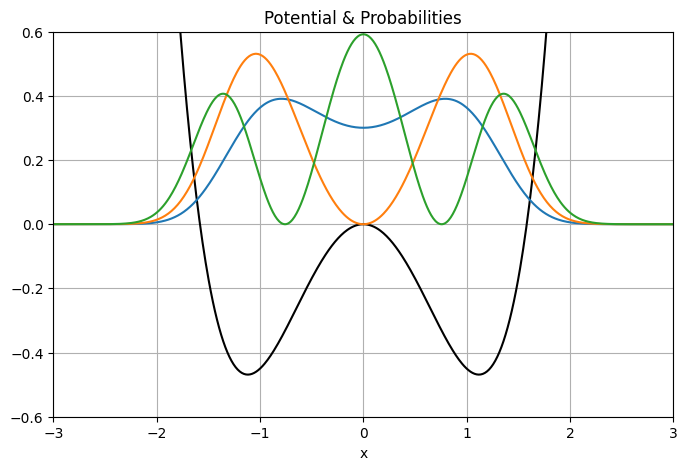

In [17]:
def Vpot(x):
    return (x**2 - 2.5)*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

# Plot a few things
plt.figure(figsize=(8,5))
scale = 0.3
plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(psi[0])**2)
plt.plot(x,(psi[1])**2)
plt.plot(x,(psi[2])**2)
plt.title("Potential & Probabilities")
plt.xlabel("x")
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
plt.show()

##### Andamento di $\langle {\hat H} \rangle_T$ al progredire del processo di Simulated Annealing

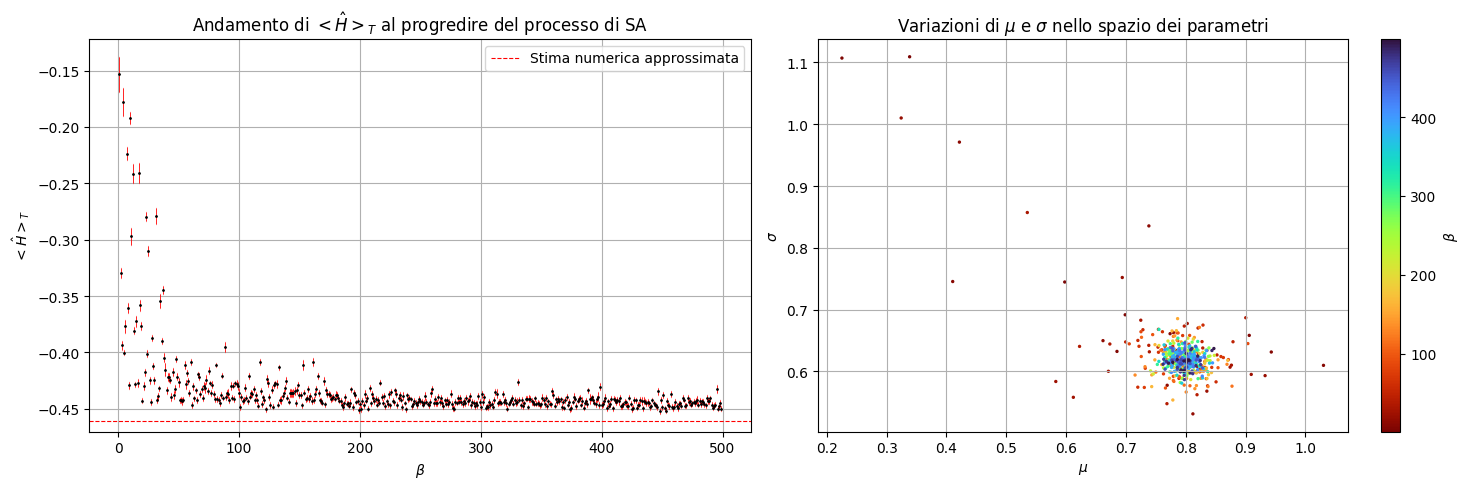

In [22]:
# Leggere i dati per il primo grafico
data_H = np.loadtxt('OUTPUT/H_SA.dat')
x_H = data_H[:, 0]  # Beta
y_H = data_H[:, 1]  # <H>
yerr_H = data_H[:, 2]  # Errore

# Creare il primo grafico
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)  # Primo grafico nella prima colonna
plt.errorbar(x_H, y_H, yerr=yerr_H, fmt='o', ecolor='r', linewidth=0.6, capsize=0.1, markersize=1, color='black')
plt.axhline(-0.46046587969271513, color='r', linestyle='--', lw=0.8, label='Stima numerica approssimata')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$<\hat{H}>_{T}$')
plt.title('Andamento di $<\hat{H}>_{T}$ al progredire del processo di SA')
plt.legend()
plt.grid(True)

# Leggere i dati per il secondo grafico
data_mu_sigma = np.loadtxt('OUTPUT/H_SA.dat')
mu = data_mu_sigma[:, 3]  # Mu
sigma = data_mu_sigma[:, 4]  # Sigma

# Creare il secondo grafico
plt.subplot(1, 2, 2)  # Secondo grafico nella seconda colonna
plt.scatter(mu, sigma, c=x_H, cmap='turbo_r', s=2)
plt.colorbar(label=r"$\beta$", orientation="vertical")
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.grid()
plt.title(r"Variazioni di $\mu$ e $\sigma$ nello spazio dei parametri")
plt.grid(True)

# Regolare lo spazio tra i due grafici
plt.tight_layout()

# Mostrare entrambi i grafici
plt.show()

A ciascuna misura di $\langle {\hat H} \rangle_T$ ho associato come errore l'errore ottenuto tramite media a blocchi.

L'algoritmo, dopo una rapida esplorazione iniziale più ampia nello spazio dei parametri, restringe il campionamento intorno al punto (0.80, 0.62), cui corrisponde un valore di $\left<\hat{H}\right>_{T} \approx -0.445$. All'aumentare del valore di $\beta$, per $\beta \gtrsim 200$, $ \left<\hat{H} \right>_{T}$ oscilla statisticamente attorno a tale valore entro un intervallo di circa $0.005$. $\left<\hat{H}\right>_{T}$ si mantiene sempre quindi maggiore del valore di energia stimato numericamente.

Per ottenere una stima dei valori ottimali $\mu_{opt}$ e $\sigma_{opt}$, ho effettuato una media sugli ultimi 200 valori esplorati nel processo di SA (a convergenza quindi già avvenuta), con un numero di cifre significative stabilito a partire dalla deviazione standard dalla media.

In [25]:
# Calcolare media e deviazione standard degli ultimi 200 valori per mu e sigma
mu_opt = np.mean(data_H[-200:, 3])
incertezza_mu = np.std(data_H[-200:, 3])
sigma_opt = np.mean(data_H[-200:, 4])
incertezza_sigma = np.std(data_H[-200:, 4])

# Stampare i risultati con due cifre decimali
print(f"Media degli ultimi duecento valori ottenuti per mu: {mu_opt:.2f}")
print(f"Deviazione standard degli ultimi duecento valori ottenuti per mu: {incertezza_mu:.2f}")
print(f"Media degli ultimi duecento valori ottenuti per sigma: {sigma_opt:.2f}")
print(f"Deviazione standard degli ultimi duecento valori ottenuti per sigma: {incertezza_sigma:.2f}")

Media degli ultimi duecento valori ottenuti per mu: 0.80
Deviazione standard degli ultimi duecento valori ottenuti per mu: 0.02
Media degli ultimi duecento valori ottenuti per sigma: 0.62
Deviazione standard degli ultimi duecento valori ottenuti per sigma: 0.01


I parametri ottimali che minimizzano l'energia sono quindi: $$ \mu_{opt} = 0.80 $$ $$ \sigma_{opt} = 0.62. $$

##### Stima di $\langle {\hat H} \rangle_T$ per la coppia di parametri ($\mu_{opt}$, $\sigma_{opt}$)

Per la coppia di parametri ($\mu_{opt}$, $\sigma_{opt})$ ho stimato $\left <\hat{H} \right>_{T}$, anche in questo caso tramite $10^5$ lanci suddivisi in $100$ blocchi. Tale valore converge a $-0.445 \pm 0.002 $, distante circa $7\sigma$ dalla stima numerica $(-0.4604)$. 

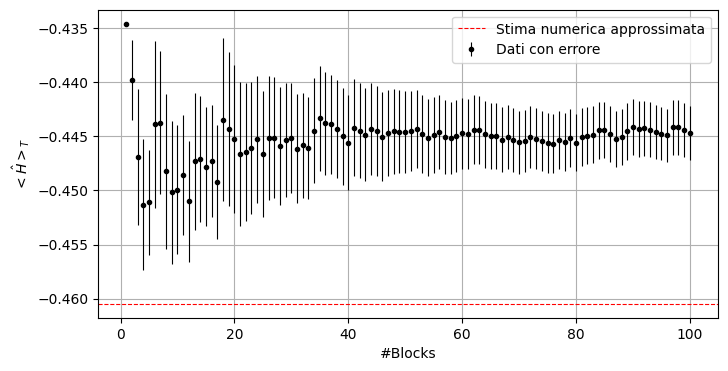

In [26]:
# Leggere i dati dal file H_final.dat
data = np.loadtxt('OUTPUT/H_final.dat')

# Estrarre le colonne
x = data[:, 0]  # Prima colonna
y = data[:, 1]  # Seconda colonna
yerr = data[:, 2]  # Terza colonna

plt.figure(figsize=(8, 4))
# Creare il grafico
plt.errorbar(x, y, yerr=yerr, fmt='o', ecolor='black', color= 'black', label='Dati con errore', markersize=3, linewidth=0.8)
plt.axhline(-0.46046587969271513, color='r', linestyle='--', lw=0.8, label='Stima numerica approssimata')
plt.xlabel('#Blocks')
plt.ylabel(r'$<\hat{H}>_{T}$')
plt.legend()
plt.grid(True)

# Mostrare il grafico
plt.show()


##### Campionamento di $|\Psi_T^{\sigma_{opt},\mu_{opt}}|^2$ 

Nel grafico sottostante sono presenti:
- l'istogramma delle coordinate ottenute campionando $|\Psi_T^{\sigma_{opt},\mu_{opt}}|^2$ con il metodo di Metropolis;
- la curva analitica $|\Psi_T^{\sigma_{opt},\mu_{opt}}|^2$ (in blu);
- la soluzione numerica ottenuta trasformando l'equazione di Schrodinger in equazione matriciale.

La densità di probabilità $|\Psi_T^{\mu_{opt}, \sigma_{opt}}(x)|^2$ si avvicina alla soluzione analitica, pur presentando massimi e minimo più pronunciati ed i massimi spostati verso lo zero rispetto alla posizione prevista dalla soluzione analitica. 

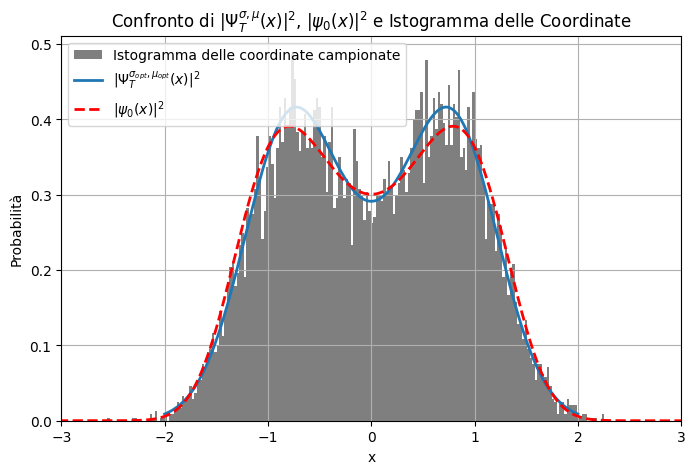

In [30]:
# File con mio campionamento
data = np.loadtxt('OUTPUT/coordinates.dat')

# Istogramma delle coordinate
hist, bins = np.histogram(data, bins=50, density=True)

# Funzione Psi_T
def psi_T(x, mu_opt, sigma_opt):
    return np.exp(-(x - mu_opt)**2 / (2 * sigma_opt**2)) + np.exp(-(x + mu_opt)**2 / (2 * sigma_opt**2))

# Valori della funzione variational Psi_T e il suo modulo quadro, poi normalizzo
x_values = np.linspace(-2, 2, 400)
psi_T_values = psi_T(x_values, mu_opt, sigma_opt)
psi_T_squared = np.abs(psi_T_values)**2

integral = np.trapz(psi_T_squared, x_values)
psi_T_squared_norm = psi_T_squared  / integral

# Grafico dei risultati sovrapposti
plt.figure(figsize=(8, 5))

# Istogramma delle coordinate
plt.hist(data, bins=200, color='black', alpha=0.5, label='Istogramma delle coordinate campionate', density=True)

# Grafico di |Psi_T^{\sigma,\mu}(x)|^2
plt.plot(x_values, psi_T_squared_norm, label=r'$|\Psi_T^{\sigma_{opt},\mu_{opt}}(x)|^2$', linewidth=2)

# Grafico di |psi_0(x)|^2
x = np.linspace(-a/2, a/2, N)
plt.plot(x, (psi[0])**2, label=r'$|\psi_0(x)|^2$', linestyle='--', color='red', linewidth=2)

# Impostazioni del grafico
plt.title('Confronto di $|\Psi_T^{\sigma,\mu}(x)|^2$, $|\psi_0(x)|^2$ e Istogramma delle Coordinate')
plt.xlabel('x')
plt.ylabel('Probabilità')
plt.legend(loc='best')
plt.grid(True)
plt.xlim(-3, 3)

# Mostra il grafico
plt.show()
